In [1]:
import pandas as pd
import numpy as np
import string
import gc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import nltk
import re
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')  # Add this line to download the missing resource
import warnings # Suppress all warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sunil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def clean(text):
  text = text.lower()
  text = text.strip()
  text = re.compile('[/(){}\[\]\|@,;]').sub(' ', text) 
  text = re.compile('[^0-9a-z #+_]').sub('', text) 
  words = text.split()
  i = 0 
  while i < len(words):
    if words[i] in stopwords.words('english'):
      words.pop(i)
    else:
      i += 1
    
    return ' '.join(map(str, words))

def lemmatize(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))    
    return ' '.join(wordlist) 

In [5]:
# Function to clean the text data
def remove_punct(text):
    return ''.join([char for char in text if char not in string.punctuation])

def clean_text(text):
    text = text.lower().strip()
    text = remove_punct(text)
    return text

# Function to lemmatize text
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')])

  

In [6]:
df = pd.read_csv('data.csv',index_col=0)

In [7]:
df['cleaned_text'] = df['Report'].apply(clean_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

# Display the DataFrame with the new columns
df.head()

,Report,speciality,cleaned_text,lemmatized_text
3,2d mmode 1 left atrial enlargement with left a...,Heart,2d mmode 1 left atrial enlargement with left a...,2d mmode 1 left atrial enlargement left atrial...
4,1 the left ventricular cavity size and wall th...,Heart,1 the left ventricular cavity size and wall th...,1 left ventricular cavity size wall thickness ...
7,2d echocardiogram multiple view of the heart a...,Heart,2d echocardiogram multiple view of the heart a...,2d echocardiogram multiple view heart great ve...
9,description 1 normal cardiac chamber size 2 no...,Heart,description 1 normal cardiac chamber size 2 no...,description 1 normal cardiac chamber size 2 no...
11,2d study 1 mild aortic stenosis widely calcifi...,Heart,2d study 1 mild aortic stenosis widely calcifi...,2d study 1 mild aortic stenosis widely calcifi...


In [8]:
df.shape

(1304, 4)

In [9]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 3), 
                             max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)

tfIdfMat = vectorizer.fit_transform(df['lemmatized_text'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)


['05', '07', '08', '10', '10 mg', '100', '11', '12', '13', '14', '15', '16', '18', '20', '20 vicryl', '2008', '24', '25', '30', '30 vicryl', '40', '50', '60', '6french', '70', '75', '80', '90', '92', '93', '95', '96', 'abdomen', 'abdomen soft', 'abdomen wa', 'abdominal', 'abdominal pain', 'abdominal wall', 'able', 'abnormal', 'abnormality', 'achieved', 'active', 'activity', 'acute', 'addition', 'additional', 'adequate', 'adhesion', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'allergy', 'alternative', 'anastomosis', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia wa', 'anesthetic', 'aneurysm', 'angiogram', 'angiography', 'anterior', 'anterior descending', 'anteriorly', 'antibiotic', 'aorta', 'aortic', 'aortic valve', 'appear', 'appeared', 'appears', 'appendix', 'applied', 'applied patient', 'appropriate', 'approximately', 'area', 'area wa', 'arm', 'arterial', 'artery', 'artery disease', 'arter

In [10]:
# Collect garbage
gc.collect()

0

In [11]:
pca = PCA(n_components=0.95)  # Reduce dimensions
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())

In [12]:
# Prepare labels
labels = df['speciality'].tolist()
category_list = df['speciality'].unique()

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels, test_size=0.2, random_state=42)

In [14]:
# Initialize models
logistic_estimator = LogisticRegression(max_iter=1000)
rf_estimator = RandomForestClassifier(random_state=42)

In [15]:
# Define parameter grids for hyperparameter tuning
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],              # Regularization type
    'solver': ['liblinear', 'saga']      # Solver algorithms
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split an internal node
}

param_grid_lgb = {
    'num_leaves': [31, 50, 100],           # Number of leaves in one tree
    'max_depth': [-1, 10, 20],             # Maximum depth of the tree
    'learning_rate': [0.01, 0.05, 0.1],    # Step size shrinkage
    'n_estimators': [100, 200, 300]        # Number of boosting rounds
}

In [16]:
# Function to perform Grid Search and evaluate the best model
def grid_search_and_evaluate(estimator, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")
    
    # Evaluate on the test set
    test_score = best_estimator.score(X_test, y_test)
    print(f"Test set score: {test_score:.4f}")
    
    return best_estimator
    
# Perform Grid Search and evaluate each model
print("\nLogistic Regression:")
best_logistic = grid_search_and_evaluate(logistic_estimator, param_grid_logistic, X_train, y_train, X_test, y_test)

print("\nRandom Forest:")
best_rf = grid_search_and_evaluate(rf_estimator, param_grid_rf, X_train, y_train, X_test, y_test)



Logistic Regression:
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.9051
Test set score: 0.9272

Random Forest:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score: 0.8485
Test set score: 0.8582


In [17]:
y_pred_lg = best_logistic.predict(X_test)
# Print classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lg, target_names=category_list))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       Heart       0.94      0.94      0.94        64
       Brain       0.89      0.89      0.89        61
Reproductive       0.94      0.97      0.95        74
   Digestive       0.95      0.90      0.93        62

    accuracy                           0.93       261
   macro avg       0.93      0.92      0.93       261
weighted avg       0.93      0.93      0.93       261



In [18]:
y_pred_rf = best_rf.predict(X_test)
# Print classification report
print("\nClassification Report RandomForest:")
print(classification_report(y_test, y_pred_rf, target_names=category_list))


Classification Report RandomForest:
              precision    recall  f1-score   support

       Heart       0.92      0.88      0.90        64
       Brain       0.83      0.79      0.81        61
Reproductive       0.83      0.93      0.88        74
   Digestive       0.86      0.82      0.84        62

    accuracy                           0.86       261
   macro avg       0.86      0.85      0.86       261
weighted avg       0.86      0.86      0.86       261



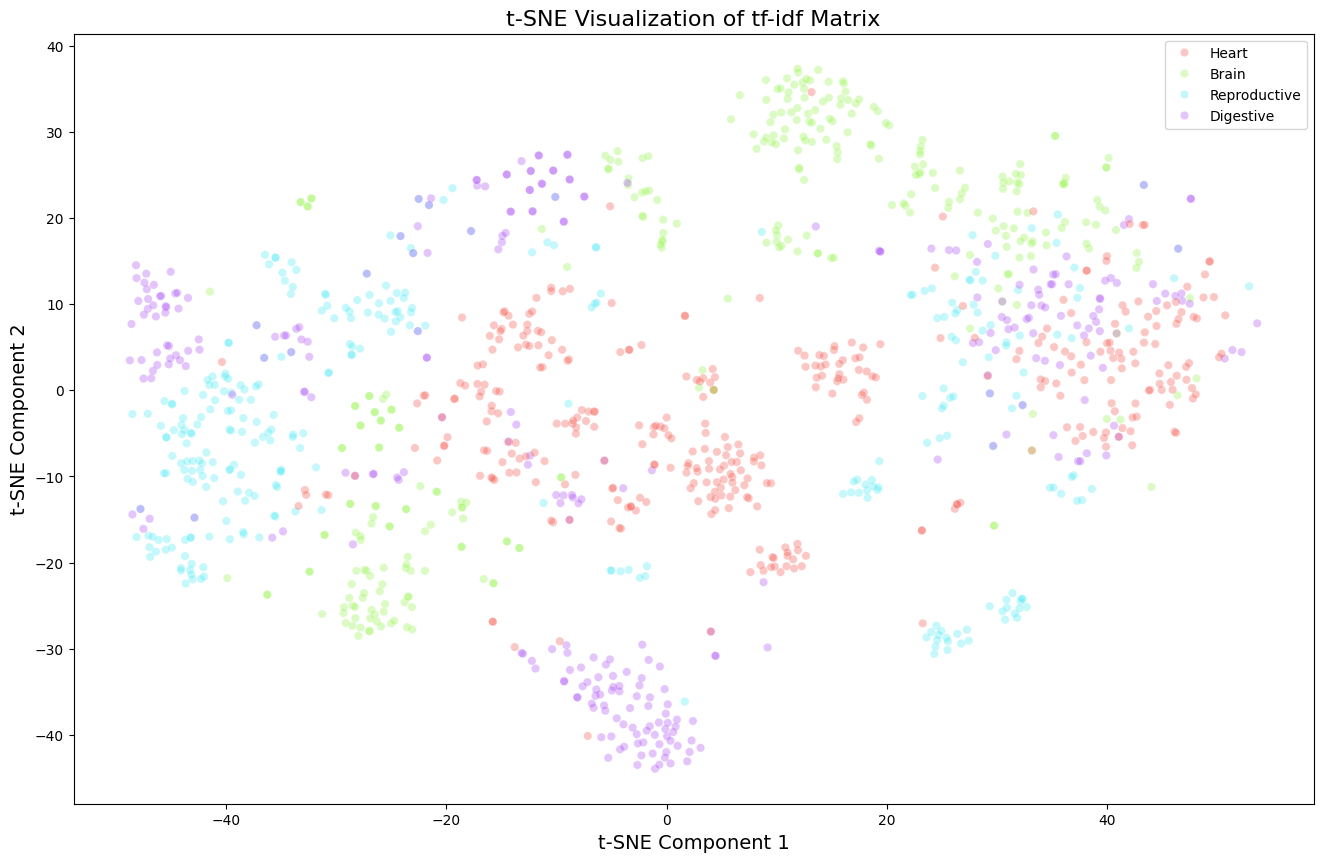

In [19]:
# Collect garbage to free up memory
gc.collect()

tfIdfMatrix = np.asarray(tfIdfMat.todense())  # Convert to numpy array
labels = df['speciality'].tolist()

# Run t-SNE
tsne_results = TSNE(n_components=2, init='random', random_state=42, perplexity=40).fit_transform(tfIdfMatrix)

# Create the plot
plt.figure(figsize=(16, 10))
palette = sns.hls_palette(4, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=labels,
    palette=palette,
    legend="full",
    alpha=0.3
)

# Add titles and labels for better readability
plt.title('t-SNE Visualization of tf-idf Matrix', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# Show the plot
plt.show()


In [23]:
import joblib
clf =best_logistic.fit(X_train, y_train)

joblib.dump(clf, 'LR.pkl')

['LR.pkl']